## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera calibration

Coner found in calibration chessboard:


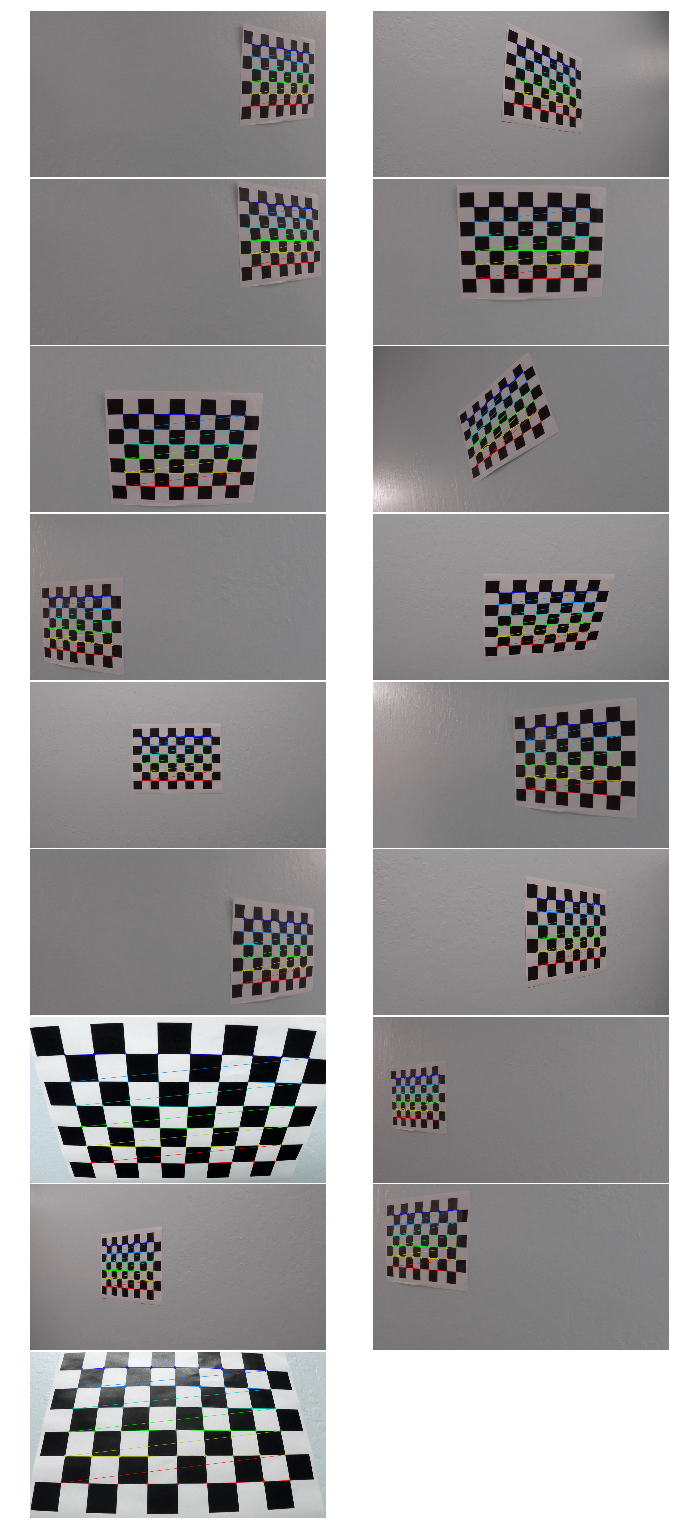

Dirstortion correction:


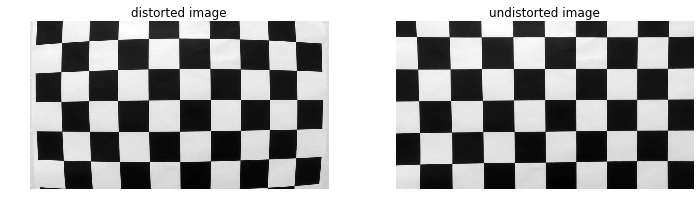

In [15]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from AdvLaneDet  import CameraCalibration as CamCalib

camera_calibraion_dir = 'camera_cal'
n_corner_x = 9
n_corner_y = 6
#get chessboard coordinates of objects and images for calibration 
objpoints,imgpoints = CamCalib.get_CameraCalib_Coord(camera_calibraion_dir,n_corner_x,n_corner_y,draw=True)
#dump to pickle file
dist_pickle = {}
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
with open('wide_dist_pickle.p', 'wb') as f:
    pickle.dump(dist_pickle, f)   
del objpoints, imgpoints
#load obj/image points
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]
# distortion correction by mapping objects and images coordinates
image_path = camera_calibraion_dir + '/calibration1.jpg'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


undist = CamCalib.calUndistort(gray, objpoints, imgpoints)
print('Dirstortion correction:')
fig = plt.figure(figsize= (6*2,3*1))
plt.subplot(121)
plt.imshow(gray,'gray')
plt.title('distorted image')
plt.axis('off')
plt.subplot(122)
plt.imshow(undist,'gray')
plt.title('undistorted image')
plt.axis('off')
plt.show()


    

## Distortion Correction

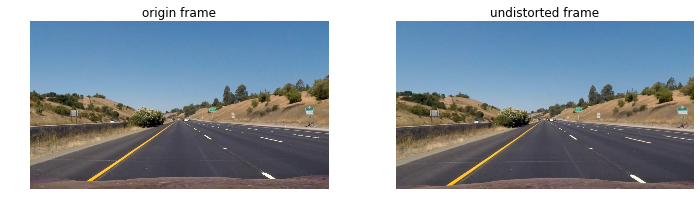

In [24]:
import glob
import numpy as np
#extract frame from video
images = glob.glob('test_images/*.jpg')
fname = images[2]
frame = plt.imread(fname)
undist = CamCalib.calUndistort(frame, objpoints, imgpoints)
fig = plt.figure(figsize= (6*2,3*1))
plt.subplot(121)
plt.imshow(frame)
plt.title('origin frame')
plt.axis('off')
plt.subplot(122)
plt.imshow(undist)
plt.title('undistorted frame')
plt.axis('off')
plt.show()

## Decide region of interest

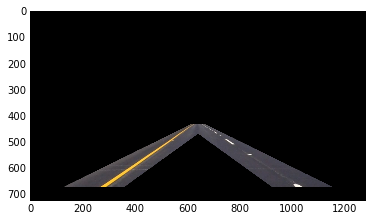

In [25]:
from AdvLaneDet import  Threshold
#set ROI
height =720
width =1280
shirk_roi_upper_edge = np.round(width *0.48)
roi_upper = np.round(0.6*height)
roi_lower = np.round(height*0.93)
roi_upper_left = (shirk_roi_upper_edge,roi_upper)
roi_upper_right = (width-shirk_roi_upper_edge, roi_upper)
roi_down_left = (np.round(width*0.1), roi_lower)
roi_down_right = (np.round(width-(width*0.1)),roi_lower)
# mask ROI insize triangle
triangle_lower_left = (np.round(width*0.28),roi_lower)
triangle_lower_right = (np.round(width-(width*0.28)),roi_lower)
triangle_top = (np.round(width*0.5),np.round(0.65*height))
ROI_vertices = np.array([[roi_upper_left,roi_down_left,triangle_lower_left,triangle_top,triangle_lower_right,roi_down_right,roi_upper_right]], dtype=np.int32)


#visualize
mask_img = Threshold.region_of_interest(undist, ROI_vertices)
plt.imshow(mask_img,cmap='gray')
plt.show()


## Binary Image 

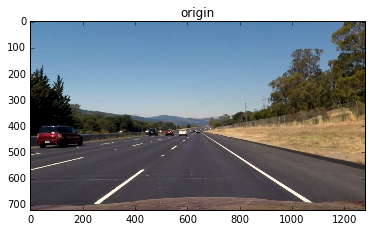

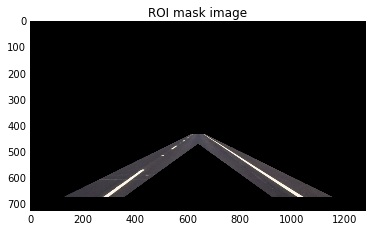

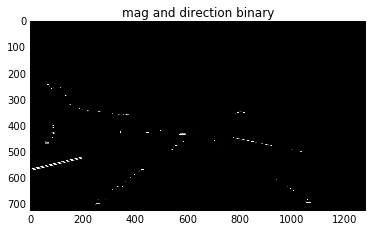

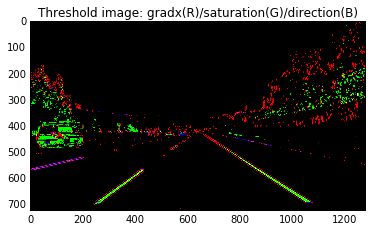

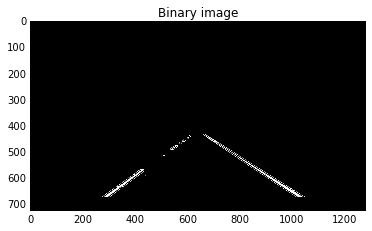

In [26]:
#load obj/image points
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]
#set ROI
height =720
width =1280
shirk_roi_upper_edge = np.round(width *0.48)
roi_upper = np.round(0.6*height)
roi_lower = np.round(height*0.93)
roi_upper_left = (shirk_roi_upper_edge,roi_upper)
roi_upper_right = (width-shirk_roi_upper_edge, roi_upper)
roi_down_left = (np.round(width*0.1), roi_lower)
roi_down_right = (np.round(width-(width*0.1)),roi_lower)
# mask ROI insize triangle
triangle_lower_left = (np.round(width*0.28),roi_lower)
triangle_lower_right = (np.round(width-(width*0.28)),roi_lower)
triangle_top = (np.round(width*0.5),np.round(0.65*height))
#  verices of ROI
ROI_vertices = np.array([[roi_upper_left,roi_down_left,triangle_lower_left,triangle_top,triangle_lower_right,roi_down_right,roi_upper_right]], dtype=np.int32)
#set threshold 
ksize = 15 
grad_thrshold = (40,100)
s_threhold = (170,255)
mag_thresh = (130,255)

images = glob.glob('test_images/*.jpg')
fname = images[1]
image = plt.imread(fname)
#distortion correction
undist = CamCalib.calUndistort(image, objpoints, imgpoints)
binary = Threshold.pipeline(undist, objpoints, imgpoints, ROI_vertices,ksize=ksize, grad_thresh=grad_thrshold, s_thresh=s_threhold,mag_thresh=mag_thresh, debug=True)

## Decide the vertices of perceptive transformation

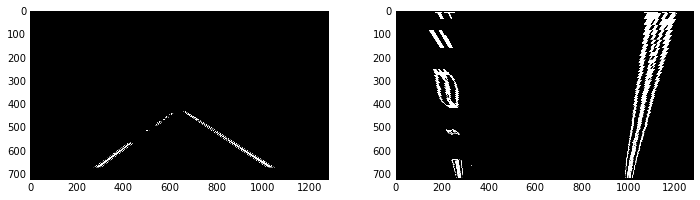

In [31]:
src = np.float32([[ 585,  460],
                  [ 203,  684],
                  [1126,  684],
                  [ 695,  460]])
dst = np.float32([[ 213,    0],
                  [ 213,  720],
                  [1066,  720],
                  [1066,    0]])
img_size = (1280,720)
M = cv2.getPerspectiveTransform(src, dst)
binary_warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_NEAREST)
fig = plt.figure(figsize= (12,3))
plt.subplot(121)
plt.imshow(binary,cmap='gray')
plt.subplot(122)
plt.imshow(binary_warped,cmap='gray')
plt.show()

## Lane Detection

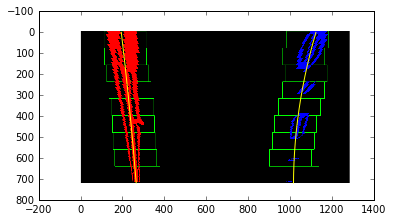

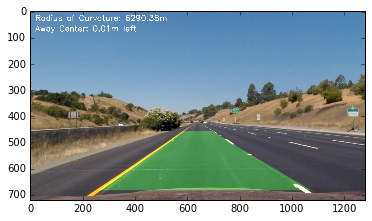

In [37]:
from AdvLaneDet import LaneDetection 
LD = LaneDetection.LaneDetection()
vid = 1
visualize = True
image= np.copy(frame)
if LD.img_size is None:
    LD.img_size = (image.shape[1],image.shape[0])

if (LD.CamCalib_objpoints is None) or (LD.CamCalib_imgpoints is None):
    #load obj/image points
    dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
    LD.objpoints = dist_pickle["objpoints"]
    LD.imgpoints = dist_pickle["imgpoints"]

if (LD.ksize is None) or (LD.grad_thrshold is None) or (LD.s_threhold is None) or (LD.mag_thresh is None):
    LD.ksize = 15 # Choose a larger odd number to smooth gradient measurements
    LD.grad_thrshold = (40,100)
    LD.s_threhold = (170,255)
    LD.mag_thresh = (130,255)

if LD.ROI_vertices is None:

    #set ROI
    if vid  == 1:
        height = LD.img_size[1]
        width = LD.img_size[0]
        shirk_roi_upper_edge = np.round(width *0.48)
        roi_upper = np.round(0.6*height)
        roi_lower = np.round(height*0.93)
        roi_upper_left = (shirk_roi_upper_edge,roi_upper)
        roi_upper_right = (width-shirk_roi_upper_edge, roi_upper)
        roi_down_left = (np.round(width*0.1), roi_lower)
        roi_down_right = (np.round(width-(width*0.1)),roi_lower)
        # mask ROI insize triangle
        triangle_lower_left = (np.round(width*0.28),roi_lower)
        triangle_lower_right = (np.round(width-(width*0.28)),roi_lower)
        triangle_top = (np.round(width*0.5),np.round(0.65*height))
        #  verices of ROI
        LD.ROI_vertices = np.array([[roi_upper_left,roi_down_left,triangle_lower_left,triangle_top,triangle_lower_right,roi_down_right,roi_upper_right]], dtype=np.int32)

    if vid == 2:
        height = LD.img_size[1]
        width = LD.img_size[0]
        shirk_roi_upper_edge = np.round(width *0.42)
        roi_upper = np.round(0.68*height)
        roi_lower = np.round(height*0.96)
        roi_upper_left = (shirk_roi_upper_edge,roi_upper)
        roi_upper_right = (width-shirk_roi_upper_edge, roi_upper)
        roi_down_left = (np.round(width*0.16), roi_lower)
        roi_down_right = (np.round(width-(width*0.08)),roi_lower)
        # mask ROI insize triangle
        triangle_lower_left = (np.round(width*0.28),roi_lower)
        triangle_lower_right = (np.round(width-(width*0.26)),roi_lower)
        triangle_top = (np.round(width*0.5),np.round(0.70*height))
        LD.ROI_vertices = np.array([[roi_upper_left,roi_down_left,triangle_lower_left,triangle_top,triangle_lower_right,roi_down_right,roi_upper_right]], dtype=np.int32)
if (LD.M is None) or (LD.Minv is None):
    #src and dist coordinate for perception transformation
    src = np.float32([[ 585,  460],
                      [ 203,  684],
                      [1126,  684],
                      [ 695,  460]])
    dst = np.float32([[ 213,    0],
                      [ 213,  720],
                      [1066,  720],
                      [1066,    0]])
    LD.M = cv2.getPerspectiveTransform(src, dst)
    LD.Minv = cv2.getPerspectiveTransform(dst, src)
if (LD.ym_per_pix is None) or (LD.xm_per_pix is None):
    # Define conversions in x and y from pixels space to meters
    LD.ym_per_pix = 30/720 # meters per pixel in y dimension
    LD.xm_per_pix = 3.7/700 # meters per pixel in x dimension

undist = CamCalib.calUndistort(image, LD.objpoints, LD.imgpoints)
binary = Threshold.pipeline(undist, LD.objpoints, LD.imgpoints, LD.ROI_vertices,ksize=LD.ksize, grad_thresh=LD.grad_thrshold, s_thresh=LD.s_threhold,mag_thresh=LD.mag_thresh, debug=False)
binary_warped = cv2.warpPerspective(binary, LD.M, LD.img_size, flags=cv2.INTER_NEAREST)

if (LD.n_prev_detected_pts_left is None) or (LD.n_prev_detected_pts_right is None):
    LD.getLanePloy(binary_warped,visualize=visualize)

elif  (LD.n_detected_pts_left < LD.n_prev_detected_pts_left/2) or (LD.n_detected_pts_right < LD.n_prev_detected_pts_right/2):
    LD.getLanePloy(binary_warped,visualize=visualize)
elif LD.line_base_pos > LD.max_bais_center:
    LD.getLanePloy(binary_warped,visualize=visualize)
else:
    LD.getNextLanePoly(binary_warped,LD.left_fit,LD.right_fit,visualize=visualize)

LD.calCurvature(LD.left_fit,LD.right_fit,LD.img_size,LD.xm_per_pix,LD.ym_per_pix)
colored_lane = LD.drawLaneRegion(binary_warped,undist,LD.Minv,LD.left_fit,LD.right_fit)
position = LD.Postion_in_Lane(LD.left_fit,LD.right_fit,LD.img_size)
LD.line_base_pos = (LD.img_size[0]/2 - position)*LD.xm_per_pix
if LD.line_base_pos  > 0 :
    text = 'right'
else:
    text = 'left'
cv2.putText(colored_lane,'Radius of Curvature: %.2fm' % LD.left_curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
cv2.putText(colored_lane,'Away Center: %.2fm %s' % (abs(LD.line_base_pos),text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

plt.imshow(colored_lane)
plt.show()